# Data Mining Versuch Verkehrsschilderkennung mit Neuronalen Netzen

* Autor: Prof. Dr. Johannes Maucher
* Datum: 01.06.2021

## Abgabe:

- **Abzugeben ist das Jupyter Notebook mit dem verlangten Implementierungen und den entsprechenden Ausgaben.**
- **Das Notebook ist als .ipynb und als .html abzugeben.**
- **Klausurelevante Fragen sind Dokument "Fragenkatalog Datamining" zu finden.**
- Antworten auf Fragen im Notebook, Diskussionen und Beschreibung der Ergebnisse sind optional (aber empfohlen) und werden nicht bewertet.

* [Übersicht Data Mining Praktikum](https://maucher.pages.mi.hdm-stuttgart.de/ai/page/dm/)


# Einführung

In diesem Versuch soll ein Convolutional Neural Network (CNN) für die Erkennung von Verkehrschildern implementiert, trainiert, evaluiert und getestet werden. Als Eingabe erhält das neuronale Netz Bilder von deutschen Verkehrsschildern. Ausgabe ist der Typ des Verkehrsschilds. Für Training und Test sind die Verkehrsschildbilder schon in separate Verzeichnissen abgelegt. Neben den Bildern selbst, enthält das zu diesem Versuch gehörende Datenverzeichnis auch Dateien mit Metadaten, die z.B. Bildeigenschaften, Verkehrsschildbedeutungen und die zugehörigen Klassenlabel beschreiben. Die Daten können Sie von hier herunterladen: https://cloud.mi.hdm-stuttgart.de/s/2mTmkPejeP8s9NL

## Lernziele:

In diesem Versuch sollen Kenntnisse in folgenden Themen vermittelt werden:

* Convolutional Neural Networks (CNNs)
* Implementierung Tiefer Neuronaler Netze mit Tensorflow und Keras: 
    - Definition der Netzarchitektur
    - Training
    - Evaluation und Test
    
* Einfache Methoden der Bildverarbeitung:
    - Augmentierung
    - Kontrastverstärkung

* Evaluation eines Klassifikators


## Vorbereitung

### Grundlagen Neuronale Netze

Machen Sie sich mit den [Grundlagen herkömmlicher Neuronaler Netze (KI Vorlesung)](https://lectures.mi.hdm-stuttgart.de/mi7ai/06NeuralNets.html) und den [Grundlagen Convolutional Neural Networks ((KI Vorlesung))](https://lectures.mi.hdm-stuttgart.de/mi7ai/06ConvolutionNeuralNetworks.html) vertraut (**user**: *mi7ai*, **pw**: *ailecture*).


### Implementierung Neuronaler Netze mit Tensorflow und Keras

Machen Sie sich mit der Implementierung von Neuronalen Netzen mit Tensorflow und Keras vertraut. Z.B. mit den [Tensorflow Quickstart Tutorials](https://www.tensorflow.org/tutorials/quickstart/beginner)

# Durchführung

In [122]:
import skimage as ski
from skimage.transform import resize
from skimage.exposure import equalize_adapthist
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report

## Vorbereitende Untersuchungen
1. Importieren Sie ein Bild aus dem Verzeichnis `Train` mit der [scikit-image.io](https://scikit-image.org/docs/stable/api/skimage.io.html)-Methode `imread()` und zeigen Sie dieses mit der Methode `imshow()` an. Geben Sie die Größe des Bildes aus (Attribut `.shape`). 

C:\Users\danna\AppData\Local\Temp\ipykernel_6176\3962486997.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  ski.io.imshow(selected_img)


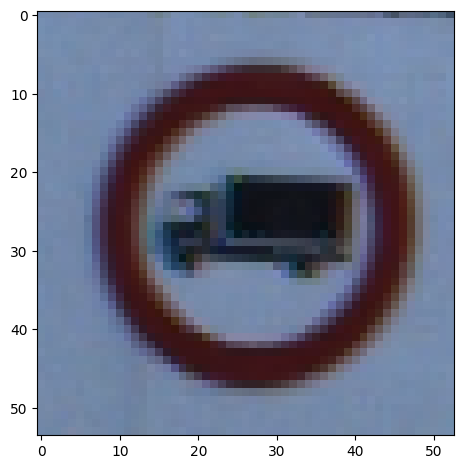

In [67]:
selected_img = ski.io.imread('traffic-sign-recognition\\data\\Test\\00000.png')
ski.io.imshow(selected_img)

In [3]:
selected_img.shape

(30, 29, 3)

2. Verändern Sie die Größe des Bildes mit der [scikit-image.transform](https://scikit-image.org/docs/stable/api/skimage.transform.html)-Methode `resize()` auf eine Größe von $32x32x3$. Die Verzerrung des Seitenverhältnisses kann dabei ignoriert werden. Diese Methode führt auch eine Normalisierung der Pixelwerte von [0,255] auf [0,1] durch.

In [4]:
selected_img = resize(selected_img, (32, 32, 3))
selected_img.shape

(32, 32, 3)

3. Führen Sie mit der [scikit-image.exposure](https://scikit-image.org/docs/stable/api/skimage.exposure.html)-Methode `equalize_adapthist()` eine Kontrastverstärkung des Bildes durch. Zeigen Sie das vergrößerte und kontrastangereicherte Bild an. **Anmerkung:** Das kontrastverstärkte Bild sieht zwar unschöner aus, auf der Basis kontrastverstärkter Bilder läßt sich aber im allgemeinen die Objekterkennung verbessern.

C:\Users\danna\AppData\Local\Temp\ipykernel_6176\2294875591.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  ski.io.imshow(selected_img)


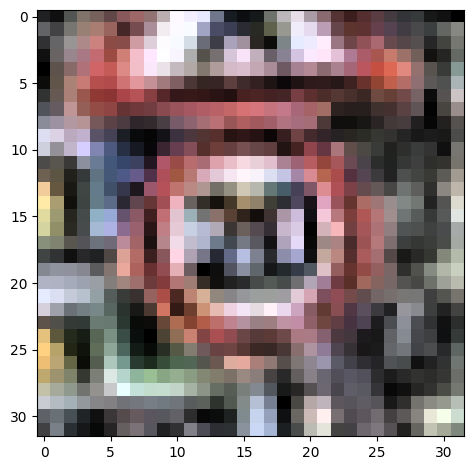

In [5]:
selected_img = equalize_adapthist(selected_img)
ski.io.imshow(selected_img)

4. Importieren Sie die Datei `Train.csv` und machen Sie sich mit deren Inhalt vertraut. Die Datei `Test.csv` ist gleich strukturiert, bezieht sich aber auf die Bilder im Verzeichnis `Test`. Wieviele Zeilen enthalten die Dateien?

In [6]:
train_data = pd.read_csv('traffic-sign-recognition\\data\\Train.csv')
train_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [7]:
print(f'Die Train.csv enthält {train_data.shape[0]} Zeilen')

Die Train.csv enthält 39209 Zeilen


In [8]:
test_data = pd.read_csv('traffic-sign-recognition\\data\\Test.csv')
test_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [9]:
print(f'Die Test.csv enthält {test_data.shape[0]} Zeilen')

Die Test.csv enthält 12630 Zeilen


5. Importieren Sie die Datei `signnames.csv` und machen Sie sich mit deren Inhalt vertraut. 

In [96]:
signnames = pd.read_csv('traffic-sign-recognition\\data\\signnames.csv')

## Funktion für den Import aller Trainings- bzw. Testbilder
Schreiben Sie eine Funktion mit folgenden Eigenschaften:
* Der Funktion wird der Name der Datei übergeben, in welcher die Metadaten stehen, also entweder `Train.csv` oder `Test.csv`.
* Rückgabewerte der Funktion sind 
    * ein 4-dimensionales numpy-array, das alle Bilder des jeweiligen Verzeichnisses (Training oder Test) enthält.
    * ein 1-dimensionales numpy-array, das die Klassenlabel aller Bilder enthält.
* Die Bilder müssen alle auf eine Größe von $32x32x3$ skaliert werden (wie in der Vorbereitungsaufgabe).
* Für alle Bilder ist eine Kontrastverstärkung durchzuführen (wie in der Vorbereitungsaufgabe).

**Tipps für die Implementierung dieser Funktion:**

Iterieren Sie mit einer for-Schleife über alle Zeilen des metadaten-Files. Pro Iteration kann dann 
* der vollständige Verzeichnis- und Filenamen ausgelesen werden,
* das entsprechende Bild mit `imread()` eingelesen werden,
* das Bild auf die vorgegebene Größe angepasst werden,
* der Kontrast des Bildes verstärkt werden.

**Wichtig:** In den von der Funktion zurückgegebenen Arrays, dürfen die Bilder nicht wie in der ursprünglichen Reihenfolge im Dateiverzeichnis enthalten sein. Um sicherzustellen, dass beim Training jedes Minibatch möglichst viele verschiedene Klassen enthält, muss die Reihenfolge geshuffelt werden. Am einfachsten ist es, wenn gleich die Zeilen des Metadatenfiles geshuffelt werden.

In [11]:
def import_file(file_name):
    file_path = f'traffic-sign-recognition\\data\\{file_name}.csv'
    data = pd.read_csv(file_path)
    data = data.sample(frac=1.0, random_state=42).reset_index(drop=True)

    imgs_number = data.shape[0]
    images = np.zeros((imgs_number, 32, 32, 3), dtype=np.float32)
    labels = np.zeros(imgs_number, dtype=np.float32)
    
    for index, row in data.iterrows():
        img = ski.io.imread(f'traffic-sign-recognition\\data\\{row["Path"]}')
        img = resize(img, (32, 32, 3))
        img = equalize_adapthist(img)

        images[index] = img
        labels[index] = row['ClassId']
    
    return images, labels

## Laden und Vorverarbeiten der Trainings- und Testdaten
1. Laden Sie mit der in der vorigen Teilaufgabe implementierten Funktion alle Trainingsbilder (`trainX`), Trainingslabel (`trainY`), Testbilder (`testX`) und Testlabel (`testY`)

In [12]:
trainX, trainY = import_file('Train')

In [13]:
testX, testY = import_file('Test')

2. Bestimmen Sie die Häufigkeitsverteilung der Klassen in den Trainings- und Testdaten. Visualisieren Sie diese.

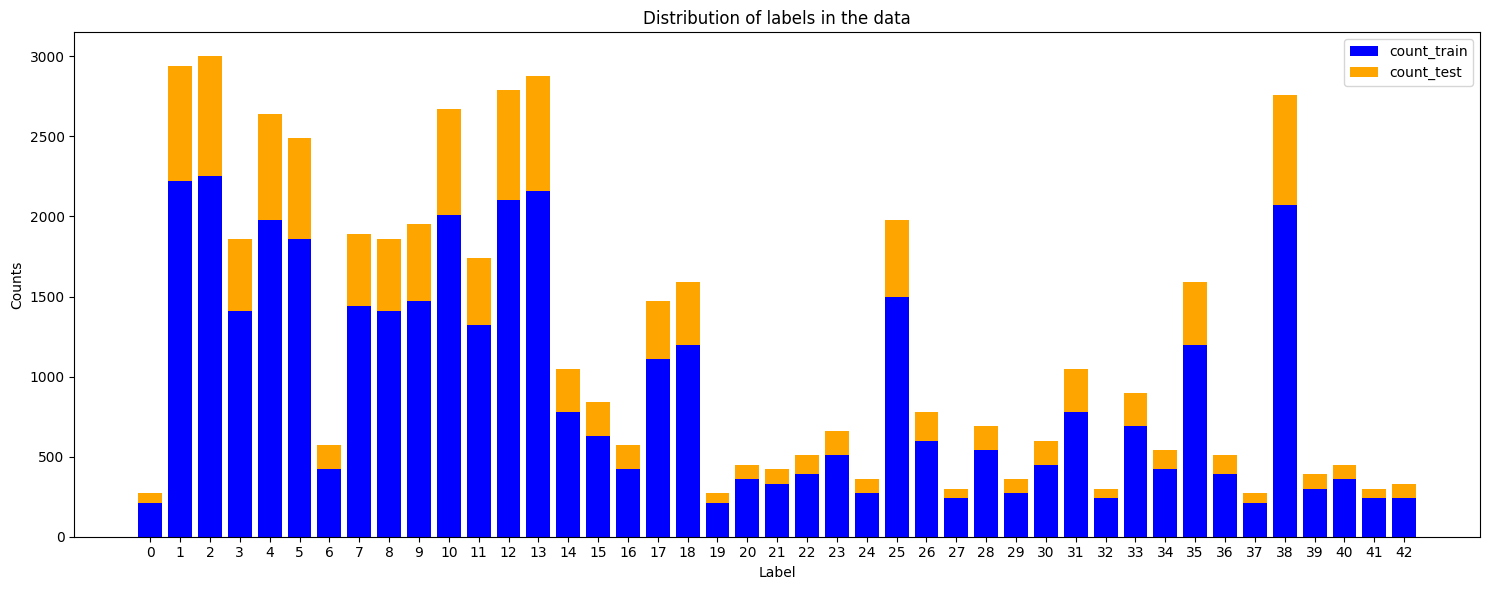

In [14]:
labels_train, l_count_train = np.unique(trainY, return_counts=True)
labels_test, l_count_test = np.unique(testY, return_counts=True)

df = pd.DataFrame({'label': labels_train, 'count_train': l_count_train, 'count_test': l_count_test})

# Create the stacked bar plot
plt.figure(figsize=(15, 6))
plt.bar(df['label'], df['count_train'], label='count_train', color='blue')
plt.bar(df['label'], df['count_test'], bottom=df['count_train'], label='count_test', color='orange')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Distribution of labels in the data')
plt.legend()
plt.xticks(df['label'])
plt.tight_layout()

# Show the plot
plt.show()

3. Alle Labels, sowohl der Trainings- als auch der Testdaten müssen One-Hot-encodiert werden.

In [15]:
lb = LabelBinarizer()

In [16]:
lb.fit(trainY)
trainY_ohe = lb.transform(trainY)

In [17]:
lb.fit(testY)
testY_ohe = lb.transform(testY)

## Definition der CNN Architektur
Schreiben Sie eine Funktion `generateCNN(width, height, depth, classes)` die eine Keras CNN-Architektur zurück gibt. Für die Definition der Architektur werden dieser Funktion die Parameter:

* `width`: Breite der Bilder
* `height`: Höhe der Bilder
* `depth`: Anzahl der Kanäle pro Bild
* `classes`: Anzahl der unterschiedlichen Klassen

übergeben. Die in der Funktion zu implementierende Architektur ist im folgenden Bild dargestellt. In der Spalte *Output shape* bezeichnen die zweite und dritte Zahl die Breite und die Höhe der einzelnen Kanäle (*Bilder*), der letzte Parameter bezeichnet die Anzahl der Kanäle (Parameter *filters* in der Konfiguration).
In der Übersichtstabelle ist die Filtergröße nicht aufgeführt. Empfohlen sind folgende Größen:
* für alle Pooling Layer: *pool_size=(2,2)*.
* für den ersten Conv2D-Layer: *kernel_size=(5,5)*.
* für alle weiteren Conv2D-Layer: *kernel_size=(3,3)*

**Anmerkung:** Der in der Tabelle mit *flatten_5* bezeichnete Layer ist nicht notwendig und erzeugt in bestimmten Keras-Versionen eine Fehlermeldung. Der Layer sollte nicht in die Architektur mit aufgenommen werden.


<img src="https://maucher.home.hdm-stuttgart.de/Pics/cnnTrafficSign.png" style="width:400px" align="middle">

In [56]:
def generateCNN(width, height, depth, classes):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=8, kernel_size=(5, 5), input_shape=(width, height, depth), padding='same'),
        tf.keras.layers.Activation(activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same'),
        tf.keras.layers.Activation(activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
        tf.keras.layers.Activation(activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
        tf.keras.layers.Activation(activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
        tf.keras.layers.Activation(activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation(activation='relu'),
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation(activation='relu'),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(units=classes),
        tf.keras.layers.Activation(activation='softmax')
        ])

    return model

## Training des CNN
Rufen Sie die im vorigen Abschnitt implementierte Funktion `generateCNN()` auf und weisen Sie die von der Funktion zurückgegebene Architektur der Variablen `model` zu. Durch Aufruf der Funktion `model.summary()` erhalten Sie eine Übersicht des erzeugten Netzes.

Für das Training soll der `Adam`-Algorithmus aus dem Modul `tensorflow.keras.optimizers` benutzt werden. `Adam` implementiert ein *Stochastic Gradient Descent*-Lernverfahren, welches die Lernraten für die Gewichte individuell und dynamisch anpasst.

In den folgenden zwei Codezellen, werden die Trainingsparameter konfiguriert:

In [57]:
model = generateCNN(32, 32, 3, 43)

c:\Users\danna\anaconda3\envs\DMaPR\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 384,603 (1.47 MB)

 Trainable params: 383,851 (1.46 MB)

 Non-trainable params: 752 (2.94 KB)

In [59]:
NUM_EPOCHS = 15 # Number of training epochs 
INIT_LR = 1e-3 # Initial Learning Rate for ADAM training
BS = 64 # Size of minibatches

In [60]:
opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR) # rename lr to learning_rate
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Für das Training sollen nicht nur die vorhandenen Trainingsbilder eingesetzt werden, sondern zusätzlich Bilder die Augmentierungen der Trainingsbilder sind. Augmentierte Bilder können mit dem `ImageDataGenerator` des Moduls `tensorflow.keras.preprocessing.image` erzeugt werden. Der Code für die Erzeugung des in diesem Projekt eingesetzten Objekts ist unten gegeben. 

**Aufgabe:** Erklären Sie was in dieser Codezelle definiert wird.

In [61]:
# construct the image generator for data augmentation
aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,      # Das Bild wird zufällig um 10 Grad gedreht
    zoom_range=0.15,        # Das Bild wird zufällig um bis zu 15% vergrößert oder verkleinert
    width_shift_range=0.1,  # Das Bild wird um bis zu 10% in seiner Breite verschoben
    height_shift_range=0.1, # Das Bild wird um bis zu 10% in seiner Höhe verschoben
    shear_range=0.15,       # Das Bild wird mit maximal 15 Grad verzerrt
    horizontal_flip=False,  # Das Bild wird nicht horizontal geflippt
    vertical_flip=False,    # Das Bild wird nicht vertikal geflippt
    fill_mode="nearest")    # Auffüllung der leeren Bereich nach Transformation = die nähsten Pixel

Das Training wird mit folgender Codezelle ausgeführt.

**Aufgabe:** Erklären Sie die Argumente der Funktion `fit()`. 

Für die Ausführung der Zelle muss das Dictionary `classWeight` angelegt sein. Dieses enthält für jede Klasse den Klassenindex als key und den relativen Anteil dieser Klasse in den Trainingsbildern als Value. Wenn z.B. 30% aller Trainingsdaten zur Klasse 0 gehören, dann wäre der Value zum Key 0 der Wert 0.3.

In [62]:
labels_train, l_count_train = np.unique(trainY, return_counts=True)

classWeight_df = pd.DataFrame({'count_train': l_count_train/sum(l_count_train)})

classWeight = classWeight_df.to_dict()['count_train']

In [63]:
# compile the model and train the network
print("[INFO] training network...")
H = model.fit(
    aug.flow(trainX, trainY_ohe, batch_size=BS),
    validation_data=(testX, testY_ohe),
    steps_per_epoch=trainX.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    verbose=1)

[INFO] training network...


c:\Users\danna\anaconda3\envs\DMaPR\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 90s 138ms/step - accuracy: 0.4214 - loss: 0.0659 - val_accuracy: 0.7726 - val_loss: 0.7263
Epoch 2/15
  1/612 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.7812 - loss: 0.0144

c:\Users\danna\anaconda3\envs\DMaPR\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7812 - loss: 0.0144 - val_accuracy: 0.7718 - val_loss: 0.7274
Epoch 3/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 59s 96ms/step - accuracy: 0.7933 - loss: 0.0138 - val_accuracy: 0.8394 - val_loss: 0.4842
Epoch 4/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9531 - loss: 0.0044 - val_accuracy: 0.8386 - val_loss: 0.4878
Epoch 5/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 55s 90ms/step - accuracy: 0.8712 - loss: 0.0080 - val_accuracy: 0.8916 - val_loss: 0.3422
Epoch 6/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9688 - loss: 0.0030 - val_accuracy: 0.8941 - val_loss: 0.3405
Epoch 7/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.9020 - loss: 0.0058 - val_accuracy: 0.9011 - val_loss: 0.3232
Epoch 8/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9062 - loss: 0.0066 - val_accuracy: 0.9020 - val_loss: 0.3166
Epoch 9/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.9247 - loss: 0.0045 - val_accuracy: 0.9

1. ``aug`` ist der zuvor definierte ``ImageDataGenrator`` für Datenaugmentation. Der ``flow``-Befehl stellt sicher, dass die Daten in Batches geladen werden und gleichzeitig die Datenaugmentation angewedent wird. ``trainX`` sind die Trainingsdaten und ``trainY`` die zugehörigen Labels. ``BS`` ist die oben definierte Batchgröße.
2. Die Testdaten und Testlabels werden in ``validation_data`` verwendet, um die Leistung des Modells auf den Testdaten zu bewerten.
3. Bei ``steps_per_epoch`` wird die Anzahl der Schritte (Batches) pro Epoche definiert. Dabei ist ``trainX.shape[0]`` die ANzahl der Trainingsbeispiele und ``BS`` die Batchgröße.
4. `epochs` gibt mit ``NUM_EPOCHS`` die Anzahl der Epochen an, also wie of das Modell die gesamten Trainigsdaten durchlaufen soll.
5. `class_weight` stellt mit `classWeight` ein Dictionarie dar, welcher die Gewichte für jede Klasse aufweist.
6. `verbose` ist zuständig für die Informationsanzeige. Mit `1` wird der Fortschritt des Trainings angezeigt, mit der Epochennummer, Verlustfunktion und der Metriken.

Visualisieren Sie die Entwicklung der *Accuracy* über dem Fortschritt der Trainingsepochen. Plotten Sie dabei die entsprechenden Kurven der Accuracy auf den Trainings- und auf den Testdaten in einen Graphen.

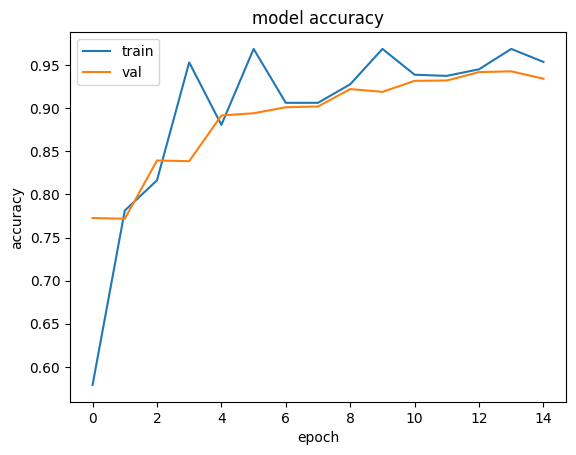

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation des gelernten Modells

Wenden Sie das gelernte CNN an, um für alle Bilder des Testdatensatzes die Art des Verkehrsschildes zu bestimmen. Evaluieren Sie die Qualität des CNN indem Sie einen `classification_report()` aus dem Modul `sklearn.metrics` erzeugen. 

1. Welche Metriken werden im Report angezeigt? Beschreiben Sie diese kurz?
2. Diskutieren Sie die Klassifikationsgenauigkeit des CNN anhand des Reports.

Zeigen Sie 5 Bilder an, die nicht korrekt klassifiziert wurden. Läßt sich die Fehlklassifikation erklären?

In [138]:
predictions = model.predict(testX)
predictions_labels = [np.argmax(predictions[index]) for index, i in enumerate(predictions)]

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [145]:
print(classification_report(testY, predictions_labels))

              precision    recall  f1-score   support

         0.0       0.44      0.32      0.37        60
         1.0       0.79      0.82      0.80       720
         2.0       0.67      0.89      0.76       750
         3.0       0.85      0.35      0.50       450
         4.0       0.75      0.82      0.78       660
         5.0       0.63      0.25      0.36       630
         6.0       0.55      0.78      0.64       150
         7.0       0.98      0.21      0.34       450
         8.0       0.45      0.90      0.60       450
         9.0       0.70      0.92      0.79       480
        10.0       0.93      0.84      0.89       660
        11.0       0.70      0.84      0.77       420
        12.0       0.94      0.87      0.91       690
        13.0       0.96      0.98      0.97       720
        14.0       0.96      0.71      0.82       270
        15.0       0.85      0.40      0.54       210
        16.0       0.00      0.00      0.00       150
        17.0       0.87    

c:\Users\danna\anaconda3\envs\DMaPR\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danna\anaconda3\envs\DMaPR\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danna\anaconda3\envs\DMaPR\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
